In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [3]:
IMAGE_DIR = r'/content/drive/MyDrive/SPIT/archive (1)/images'       # Folder containing pothole images
ANNOTATION_DIR = r'/content/drive/MyDrive/SPIT/archive (1)/annotations' # Folder containing XML annotations
MASK_DIR = r'/content/drive/MyDrive/SPIT/archive (1)/masks'

In [4]:
def create_masks_from_annotations(image_dir, annotation_dir, mask_dir, img_size=(400, 400)):
    for xml_file in os.listdir(annotation_dir):
        if not xml_file.endswith('.xml'):
            continue

        tree = ET.parse(os.path.join(annotation_dir, xml_file))
        root = tree.getroot()

        filename = root.find('filename').text
        img_path = os.path.join(image_dir, filename)

        # Read and resize image
        image = cv2.imread(img_path)
        image = cv2.resize(image, img_size)
        height, width, _ = image.shape

        # Create blank mask
        mask = np.zeros((height, width), dtype=np.uint8)

        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            # Draw white rectangle on mask
            cv2.rectangle(mask, (xmin, ymin), (xmax, ymax), color=255, thickness=-1)

        # Save mask with same filename as image
        mask_path = os.path.join(mask_dir, filename.replace('.png', '_mask.png'))
        cv2.imwrite(mask_path, mask)

# Run function to generate masks
create_masks_from_annotations(IMAGE_DIR, ANNOTATION_DIR, MASK_DIR)

KeyboardInterrupt: 

In [4]:
def load_images_and_masks(image_dir, mask_dir, img_size=(400, 400)):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('_mask.png')])

    images, masks = [], []

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Read and preprocess image
        image = cv2.imread(img_path)
        image = cv2.resize(image, img_size)
        image = image / 255.0  # Normalize
        images.append(image)

        # Read and preprocess mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = mask / 255.0  # Normalize mask
        masks.append(mask)

    return np.array(images), np.array(masks).reshape(-1, img_size[0], img_size[1], 1)

# Load dataset
X, y = load_images_and_masks(IMAGE_DIR, MASK_DIR)

In [5]:
 from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the split data shapes
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


(532, 400, 400, 3) (133, 400, 400, 3) (532, 400, 400, 1) (133, 400, 400, 1)


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

# Define U-Net model with a pre-trained VGG16 encoder
def unet_model(input_size=(400, 400, 3)):
    # Load VGG16 pre-trained model as the encoder (without the top classification layer)
    vgg16 = VGG16(input_shape=input_size, include_top=False, weights='imagenet')

    # Freeze the layers of VGG16 to retain its learned features
    vgg16.trainable = False

    # Encoder (Contracting Path using VGG16 layers)
    c1 = vgg16.get_layer('block1_conv2').output  # Output from block1 (64 filters)
    c2 = vgg16.get_layer('block2_conv2').output  # Output from block2 (128 filters)
    c3 = vgg16.get_layer('block3_conv3').output  # Output from block3 (256 filters)
    c4 = vgg16.get_layer('block4_conv3').output  # Output from block4 (512 filters)

    # Decoder (Expanding Path)
    u5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])  # Concatenate with block3
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])  # Concatenate with block2
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])  # Concatenate with block1
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    # Create the model
    model = models.Model(inputs=vgg16.input, outputs=outputs)

    return model


In [7]:
model = unet_model(input_size=(400, 400, 3))

In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [9]:
# Assuming you already have the images and masks loaded
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val))


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 235s 4s/step - accuracy: 0.7643 - loss: 1.0729 - val_accuracy: 0.8570 - val_loss: 0.4153
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8520 - loss: 0.4201 - val_accuracy: 0.8555 - val_loss: 0.4108
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8558 - loss: 0.4067 - val_accuracy: 0.8571 - val_loss: 0.3931
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8549 - loss: 0.4016 - val_accuracy: 0.8397 - val_loss: 0.4563
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8462 - loss: 0.4286 - val_accuracy: 0.8571 - val_loss: 0.3892
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8563 - loss: 0.3907 - val_accuracy: 0.8571 - val_loss: 0.3911
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8560 - loss: 0.3939 - val_accuracy: 0.8570 - val_loss: 0.3925
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.8522 - loss: 0.3942 - val_accuracy: 0.8570 - val_loss

NameError: name 'train_images' is not defined

In [10]:
model.save('pothole_segmentation_model2.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


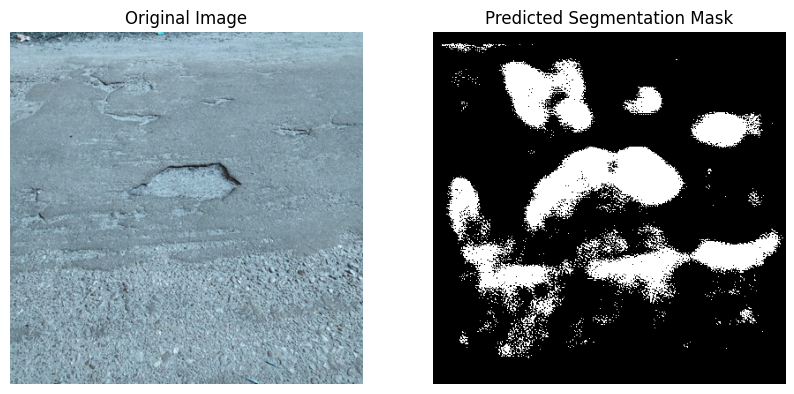

In [16]:
def predict_and_show(model, image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (400, 400))
    image_norm = image / 255.0
    image_input = np.expand_dims(image_norm, axis=0)

    # Get prediction
    pred_mask = model.predict(image_input)
    pred_mask = (pred_mask > 0.2).astype(np.uint8)

    # Show results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title("Predicted Segmentation Mask")
    plt.axis('off')
    plt.show()

# Test on a new image
test_image_path = r'/content/drive/MyDrive/SPIT/archive (1)/images/potholes47.png'
predict_and_show(model, test_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


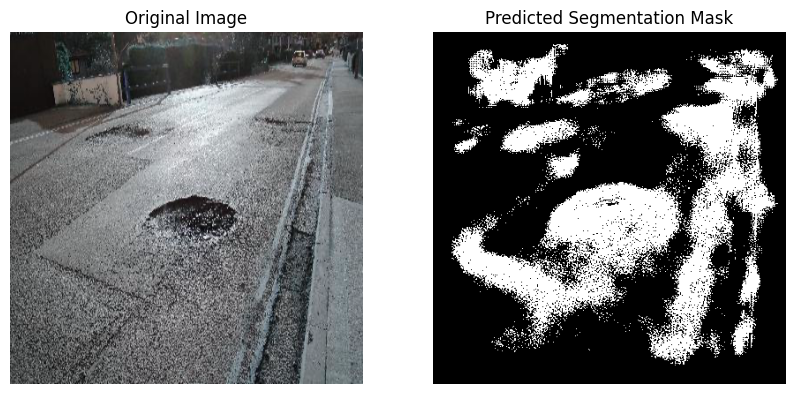

Pothole coverage: 29.09%


In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_pothole_area(pred_mask):
    # Calculate the total number of pixels in the mask
    total_pixels = pred_mask.size

    # Calculate the number of pixels that are part of the pothole (i.e., where the mask is 1)
    pothole_pixels = np.sum(pred_mask)

    # Calculate the percentage of the image covered by potholes
    pothole_percentage = (pothole_pixels / total_pixels) * 100

    return pothole_percentage

def predict_and_show(model, image_path):
    # Read the image from the provided path
    image = cv2.imread(image_path)

    # Check if the image was loaded correctly
    if image is None:
        print(f"Error: Unable to load image from {image_path}")
        return

    # Resize image to match the input size of the model (assuming it's 400x400)
    image = cv2.resize(image, (400, 400))

    # Normalize the image to range [0, 1]
    image_norm = image / 255.0

    # Add batch dimension (model expects a batch of images)
    image_input = np.expand_dims(image_norm, axis=0)

    # Predict the mask using the model
    pred_mask = model.predict(image_input)

    # Threshold the predicted mask to obtain binary values
    pred_mask = (pred_mask > 0.2).astype(np.uint8)

    # Display original image and predicted mask side by side
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask.squeeze(), cmap='gray')  # Squeeze to remove batch dimension
    plt.title("Predicted Segmentation Mask")
    plt.axis('off')

    plt.show()

    # Calculate the area covered by potholes in the predicted mask
    pothole_percentage = calculate_pothole_area(pred_mask.squeeze())
    print(f"Pothole coverage: {pothole_percentage:.2f}%")

# Example: Test on a new image
test_image_path = r'/content/drive/MyDrive/SPIT/archive (1)/images/potholes58.png'
predict_and_show(model, test_image_path)
